In [14]:
import os
import pickle
import numpy as np
import pandas as pd
from sbi.inference import SNPE
from sbi.utils import get_density_thresholder, RestrictedPrior
from sbi.analysis import pairplot
import torch
import json
import matplotlib.pyplot as plt
from parflow.tools.io import read_pfb, read_clm
import subsettools as st
import hf_hydrodata as hf
import random
import glob
import matplotlib.dates as mdates
#read in variables from the json file
json_path = '/home/at8471/c2_sbi_experiments/hydrogen-sbi/scripts/settings.json' #probably need a better way to do this step
with open(json_path, 'r') as file:
    settings = json.load(file)
    
base_dir = settings['base_dir']
grid = settings['grid']
huc = settings['huc']
temporal_resolution = settings['temporal_resolution']
runname=settings['runname']
variable_list = settings['variable_list']
num_sims = settings['num_sims']
ens_num=settings['ens_num']
num_samples = settings['num_samples']
quantile = settings['quantile']
obsv_path=settings['observation_path']
mannings_name = settings['base_mannings_file']
seed=settings['random_seed']

metadata_path=f'{base_dir}/outputs/{runname}/streamflow_daily_metadf.csv'


#set the random seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [28]:
#get orig mannings map
orig_mannings = read_pfb(f"{base_dir}/outputs/{runname}/{mannings_name}.pfb").squeeze()
new_name_list=[0,1,2,3,4,5]
category_labels = ['M0','M1','M2','M3','M4','M5']

filtered_df=pd.read_csv('/home/at8471/c2_sbi_experiments/sbi_framework/sinnemahoning_filtered_orig_vals.csv')
orig_mannings_tensor = torch.tensor(filtered_df.iloc[0].to_numpy(), dtype=torch.float)

In [29]:
orig_vals_path = f"{base_dir}/{runname}_filtered_orig_vals.csv"
filtered_df=pd.read_csv(orig_vals_path)

In [30]:
new_mannings = orig_mannings.copy()
for col,new_name in zip(filtered_df.columns,new_name_list):
        orig_val = filtered_df[col][0]
        new_mannings[new_mannings == orig_val] = new_name

In [31]:
cmap = plt.get_cmap('Set1', len(new_name_list))

Text(0.5, 1.0, 'Mannings Params by Group \nSinnemahoning (HUC 02050202)')

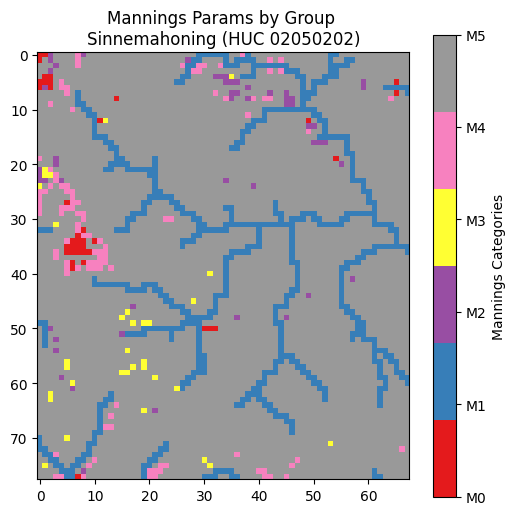

In [39]:
plt.figure(figsize=(6, 6))
im = plt.imshow(new_mannings, cmap=cmap, label=category_labels)
cbar = plt.colorbar(im, ticks=np.arange(len(new_name_list)))
cbar.set_label('Mannings Categories')
cbar.set_ticklabels(category_labels) 
plt.title("Mannings Params by Group \nSinnemahoning (HUC 02050202)")

Drawing 10000 posterior samples: 10481it [00:00, 21464.67it/s]                          
Drawing 10000 posterior samples: 11030it [00:00, 18725.78it/s]                          
Drawing 10000 posterior samples: 10539it [00:00, 10545.16it/s]                          
Drawing 10000 posterior samples: 11252it [00:00, 13275.58it/s]                          
Drawing 10000 posterior samples: 11787it [00:00, 15550.41it/s]                          


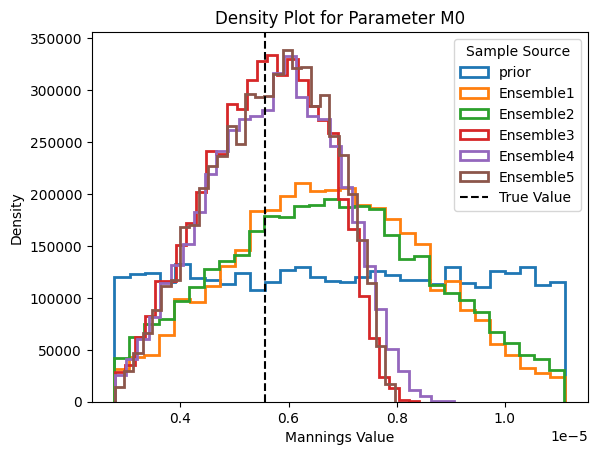

Drawing 10000 posterior samples: 10460it [00:00, 21726.46it/s]                          
Drawing 10000 posterior samples: 10907it [00:00, 19038.87it/s]                          
Drawing 10000 posterior samples: 10463it [00:00, 10827.60it/s]                          
Drawing 10000 posterior samples: 11253it [00:00, 13244.82it/s]                          
Drawing 10000 posterior samples: 11826it [00:00, 15242.59it/s]                          


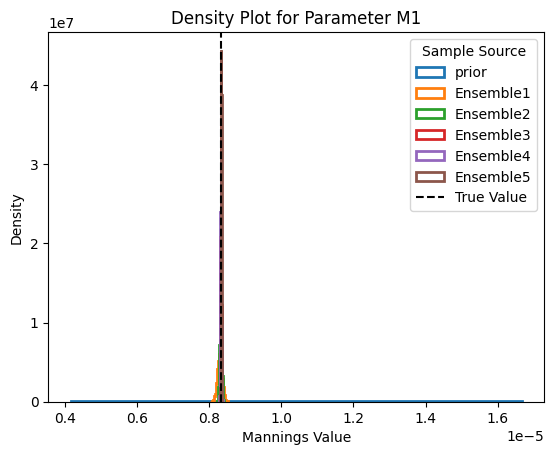

Drawing 10000 posterior samples: 10450it [00:00, 21348.83it/s]                          
Drawing 10000 posterior samples: 10987it [00:00, 18634.69it/s]                          
Drawing 10000 posterior samples: 10523it [00:00, 10673.39it/s]                          
Drawing 10000 posterior samples: 11165it [00:00, 13154.36it/s]                          
Drawing 10000 posterior samples: 11752it [00:00, 15403.18it/s]                          


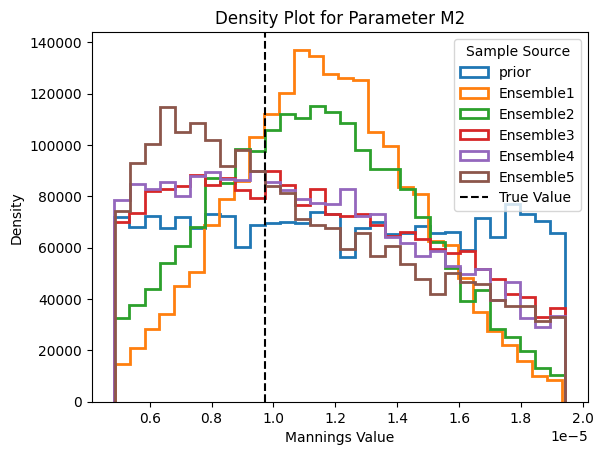

Drawing 10000 posterior samples: 10479it [00:00, 21699.71it/s]                          
Drawing 10000 posterior samples: 10976it [00:00, 18942.98it/s]                          
Drawing 10000 posterior samples: 10523it [00:00, 10600.46it/s]                          
Drawing 10000 posterior samples: 11097it [00:00, 12858.73it/s]                          
Drawing 10000 posterior samples: 11561it [00:00, 15372.33it/s]                          


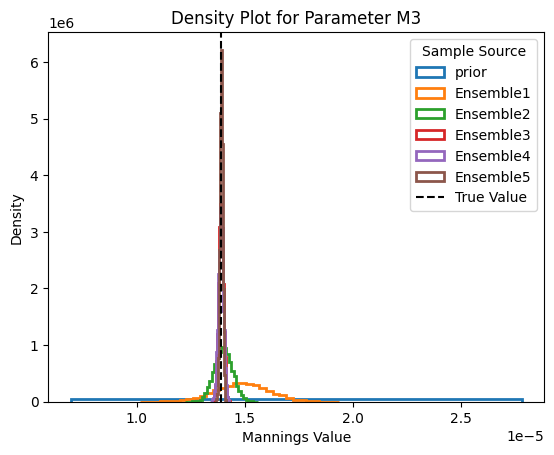

Drawing 10000 posterior samples: 10468it [00:00, 21616.31it/s]                          
Drawing 10000 posterior samples: 10985it [00:00, 18434.65it/s]                          
Drawing 10000 posterior samples: 10491it [00:00, 10822.89it/s]                          
Drawing 10000 posterior samples: 11301it [00:00, 13262.30it/s]                          
Drawing 10000 posterior samples: 11845it [00:00, 15267.34it/s]                          


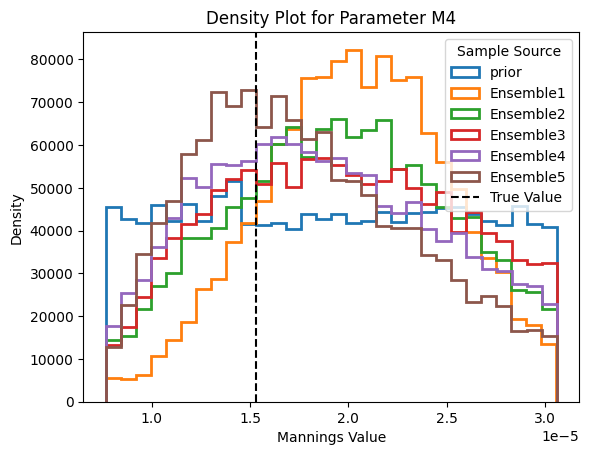

Drawing 10000 posterior samples: 10481it [00:00, 21694.09it/s]                          
Drawing 10000 posterior samples: 10996it [00:00, 18912.09it/s]                          
Drawing 10000 posterior samples: 10457it [00:00, 10632.04it/s]                          
Drawing 10000 posterior samples: 11364it [00:00, 13397.15it/s]                          
Drawing 10000 posterior samples: 11612it [00:00, 15429.99it/s]                          


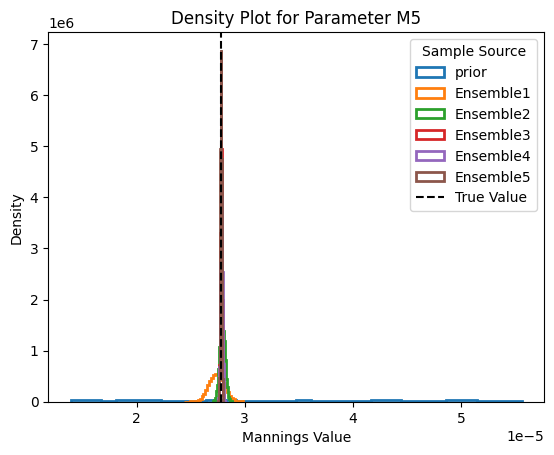

In [38]:
ens_num=6
for j in range(6):
    for i in range(ens_num):
        if i > 0:
            with open(f"{base_dir}/{runname}_posterior{i-1}.pkl", "rb") as fp:
                posterior=pickle.load(fp)
            label=f"Ensemble{i}"
        else:
            with open(f"{base_dir}/{runname}_prior.pkl", "rb") as fp:
                posterior=pickle.load(fp)
            label="prior"
                
        samples = posterior.sample((10000,))
        
        plt.hist(samples[:, j].numpy(),bins=30,density=True,histtype='step',linewidth=2,label=label)
        
    plt.axvline(x=orig_mannings_tensor[j].item(), color='k', linestyle='--', label='True Value')
    plt.title(f'Density Plot for Parameter M{j}')
    plt.xlabel(f'Mannings Value')
    plt.ylabel('Density')
    plt.legend(loc='upper right', title='Sample Source')
    plt.savefig(f'{base_dir}/plots/param{j}_hist_all_ens.png', dpi=300, bbox_inches='tight', format='png')
    plt.show()
    plt.close()

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


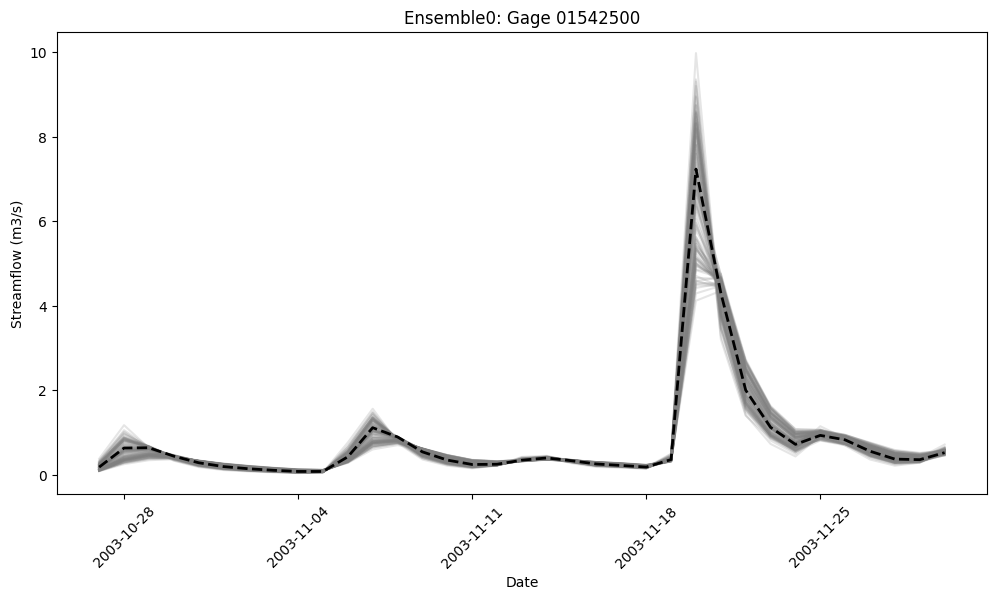

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


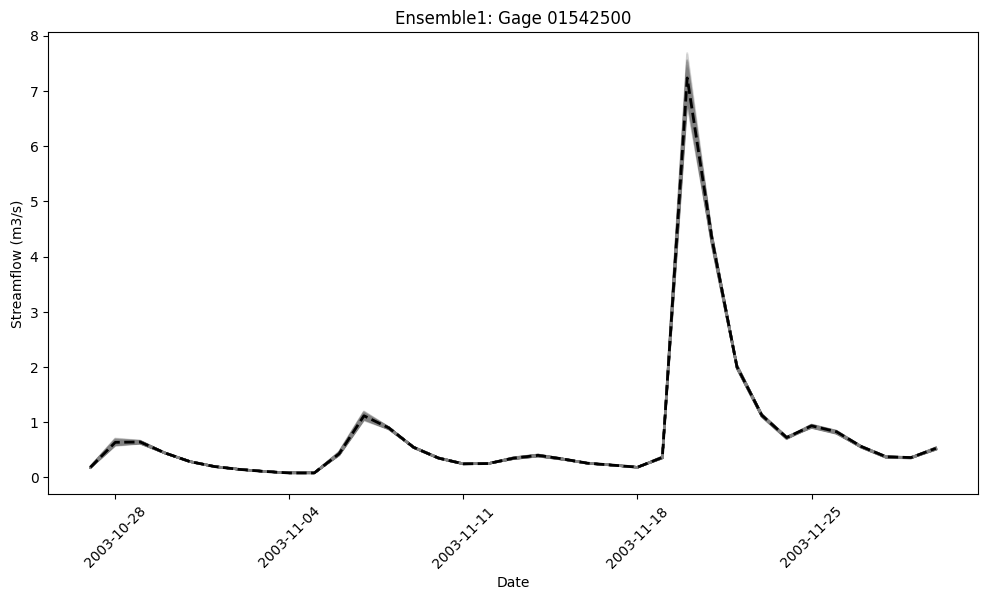

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


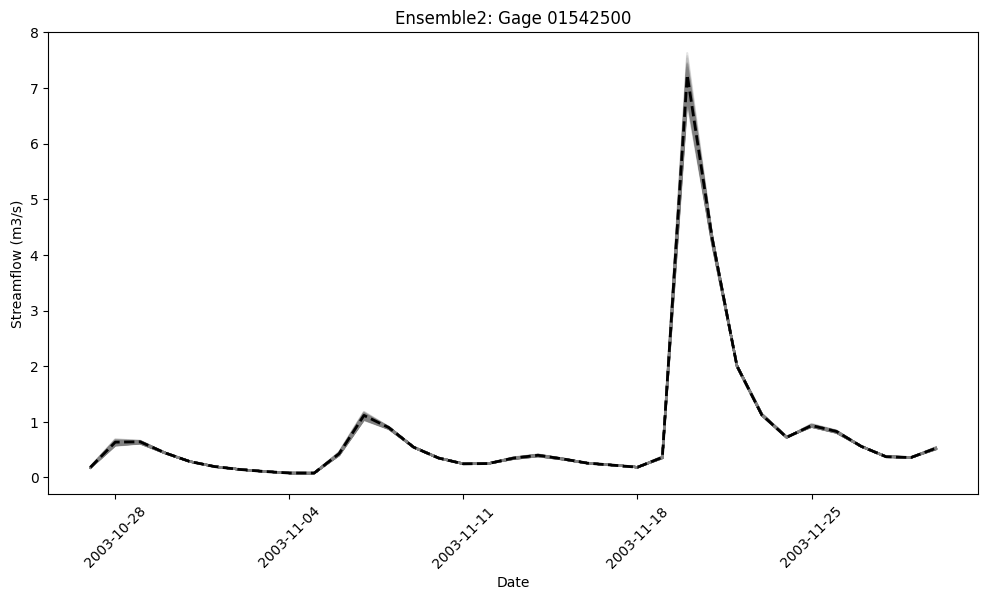

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


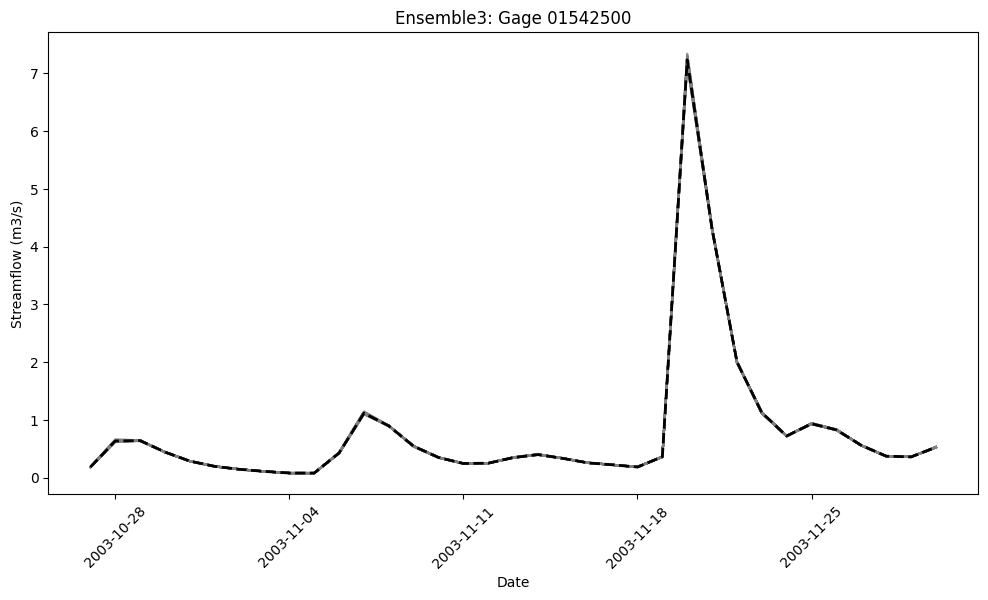

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


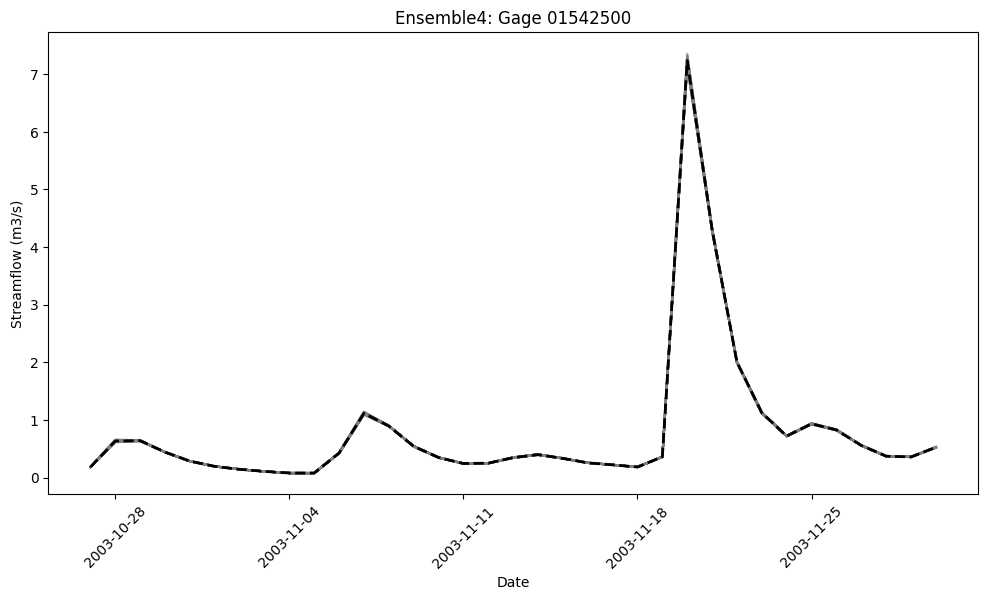

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


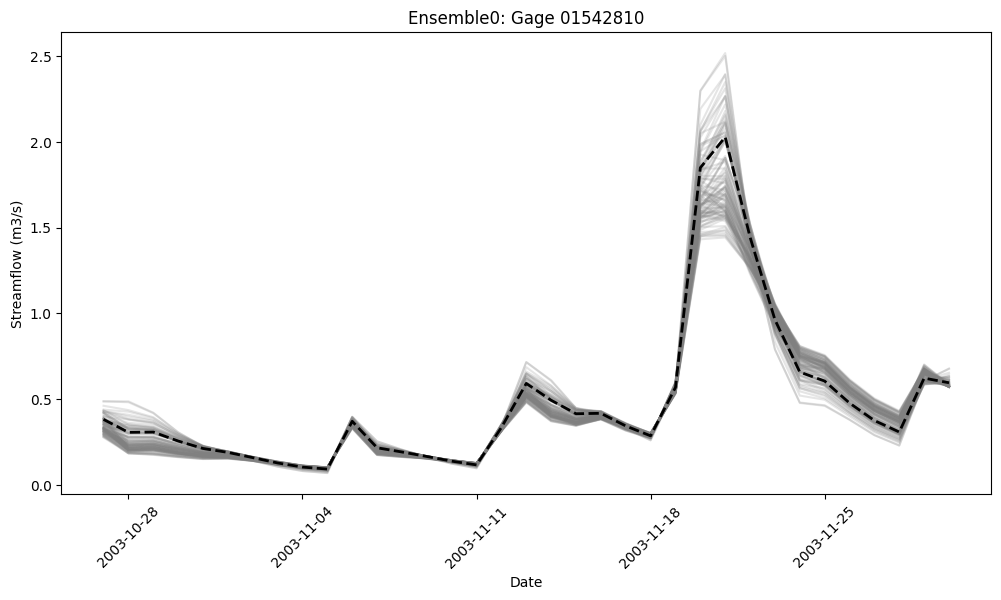

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


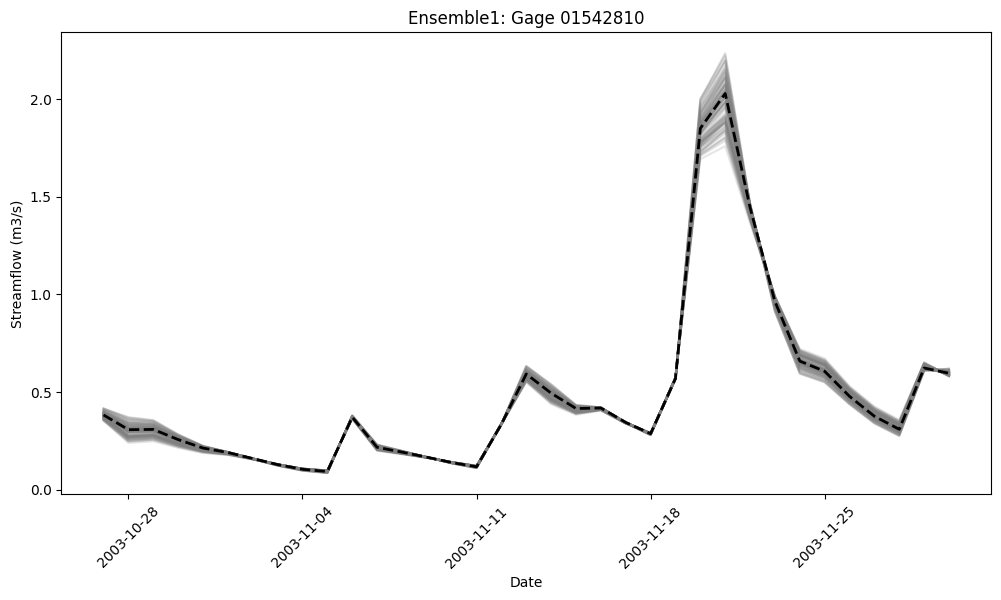

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


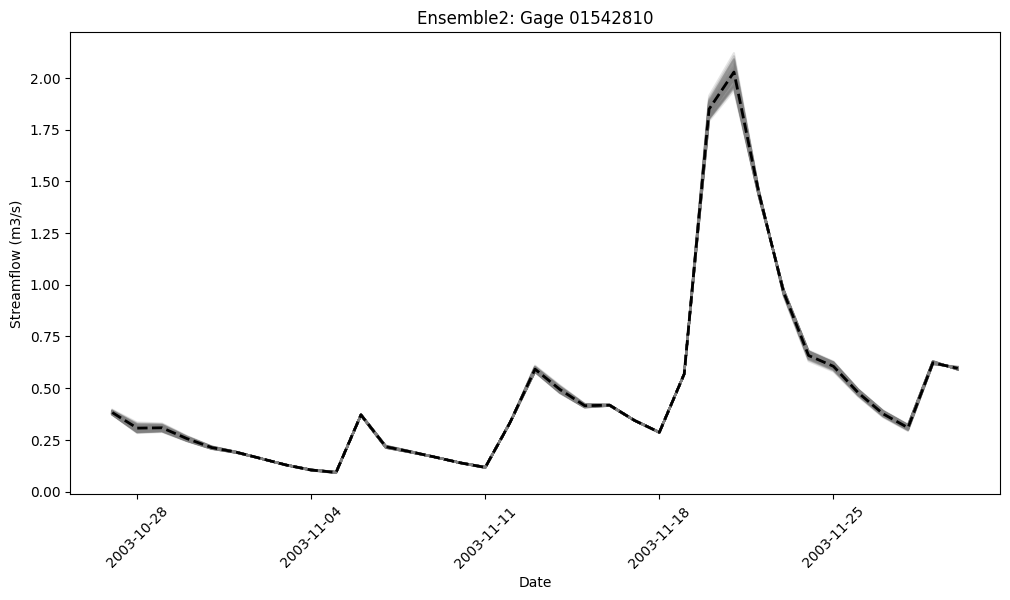

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


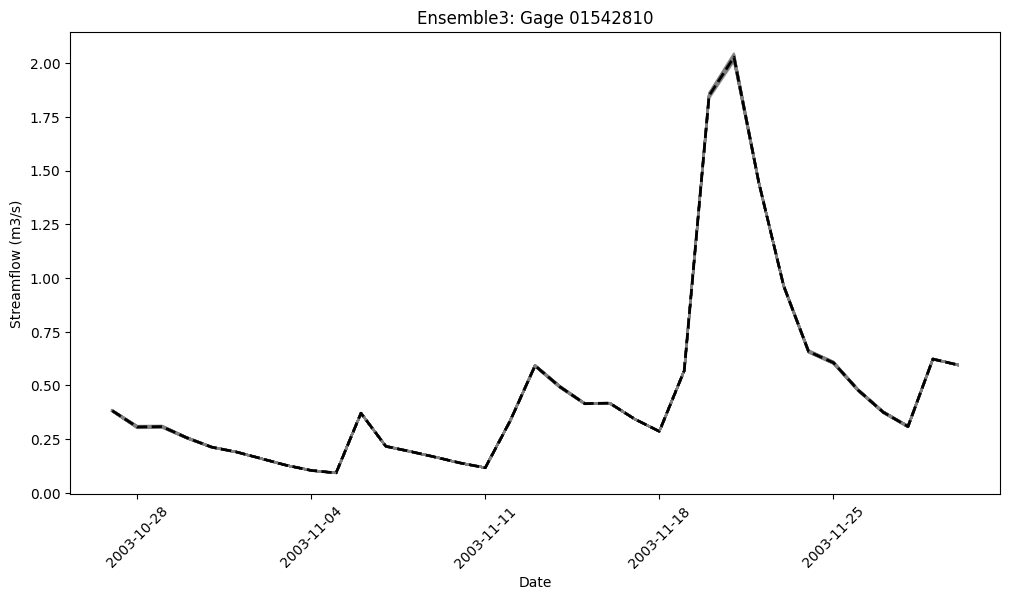

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


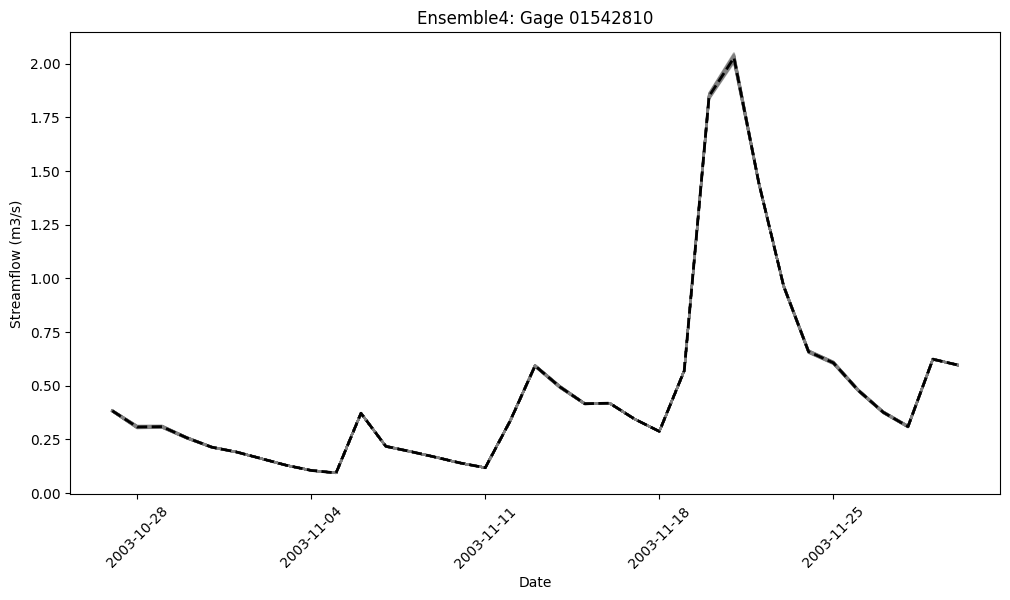

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


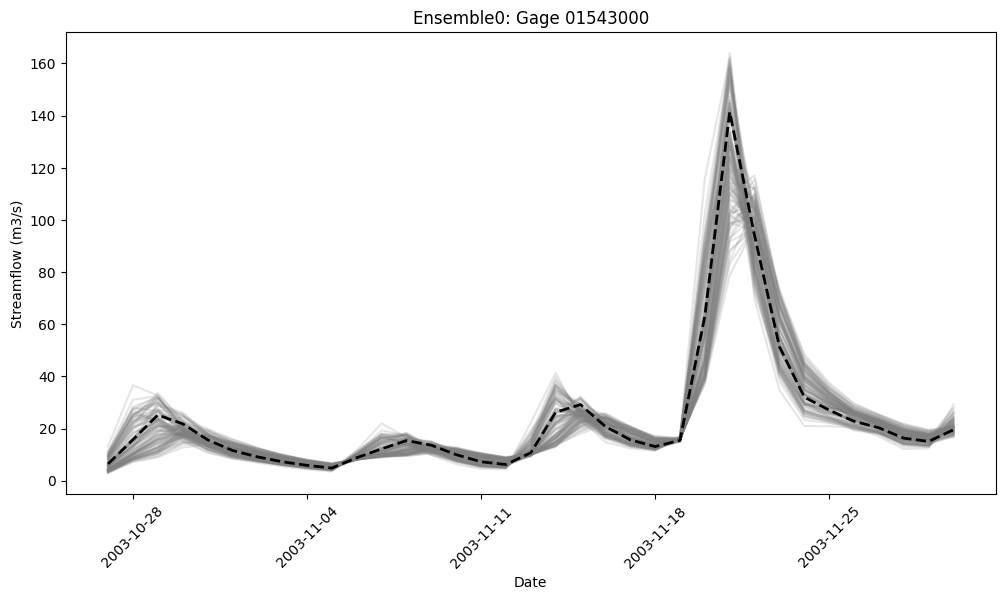

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


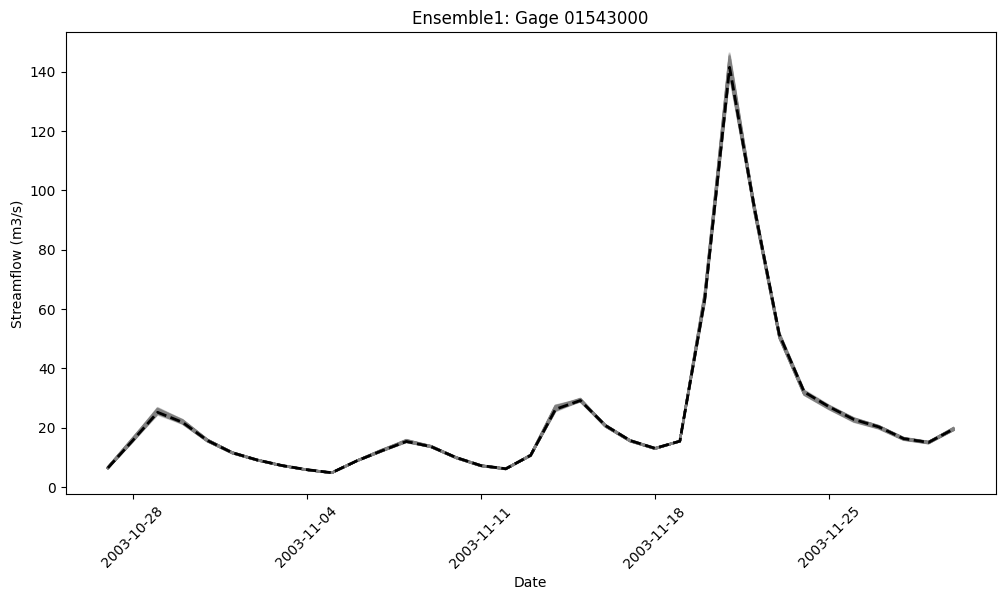

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


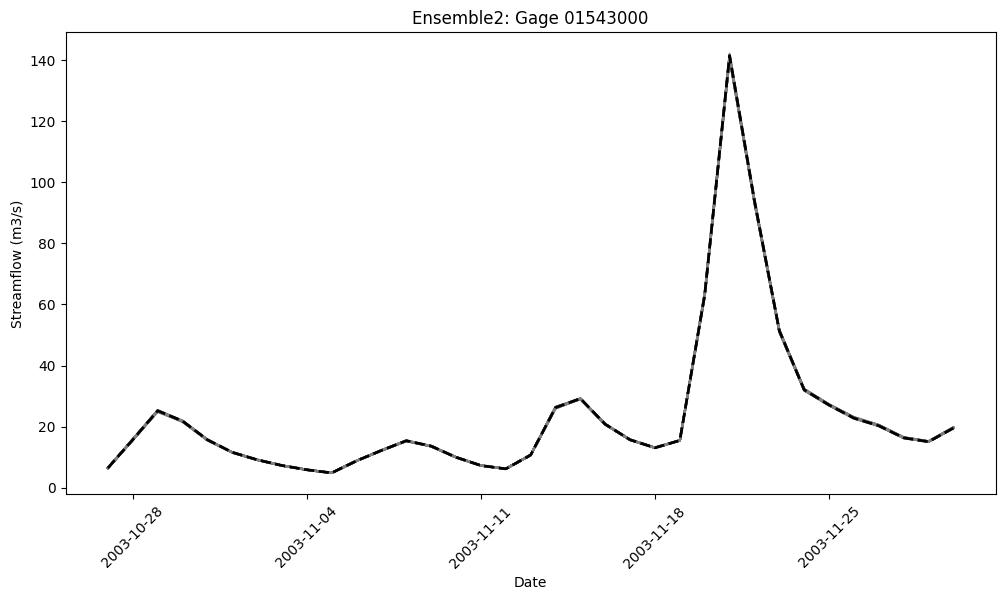

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


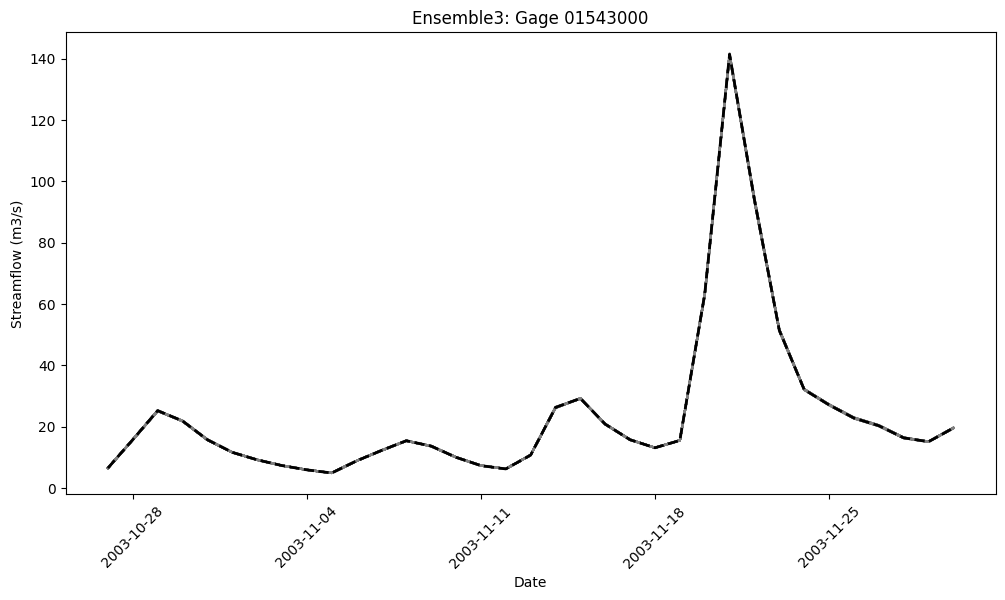

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


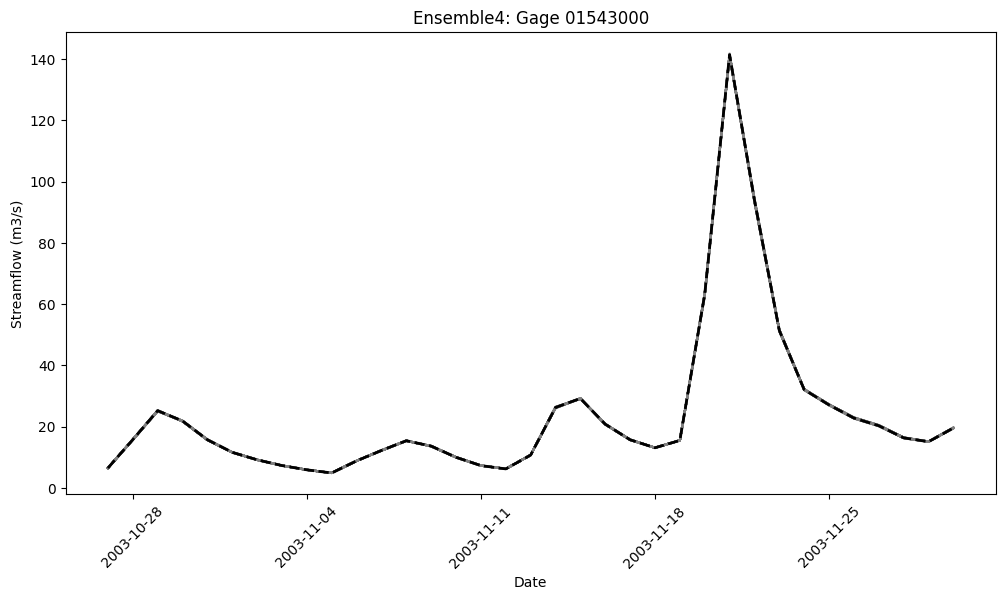

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


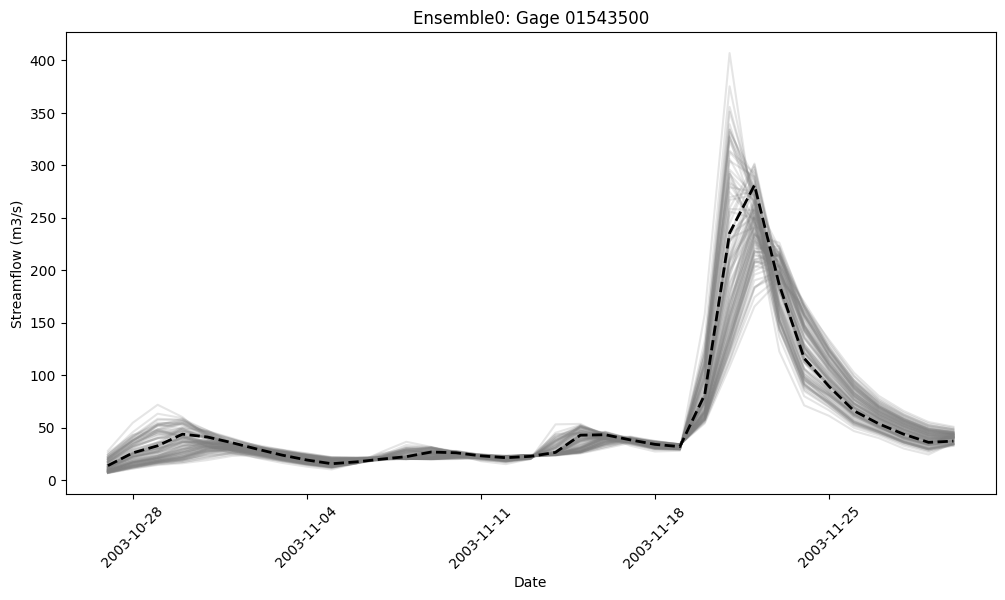

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


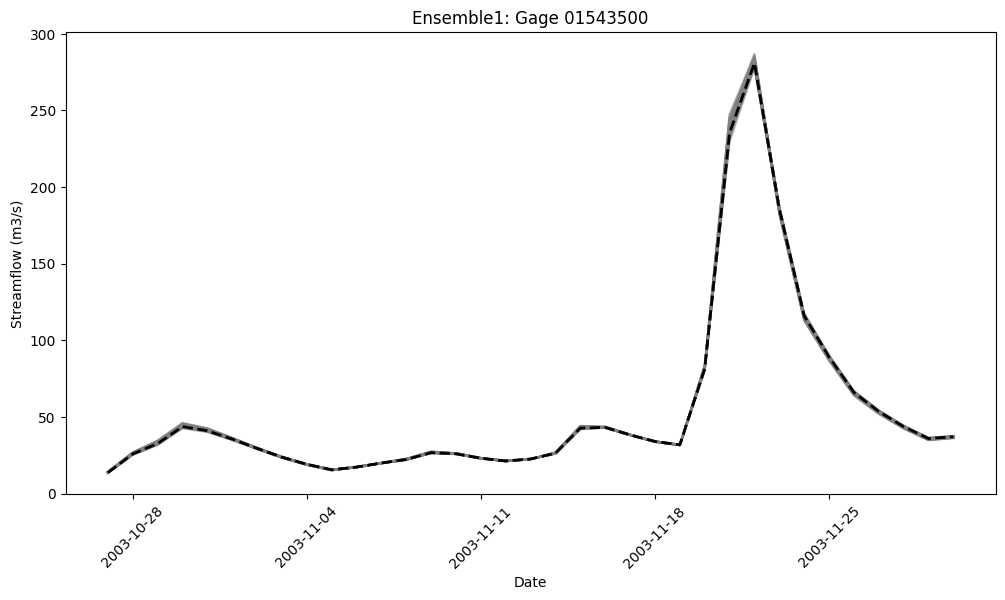

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


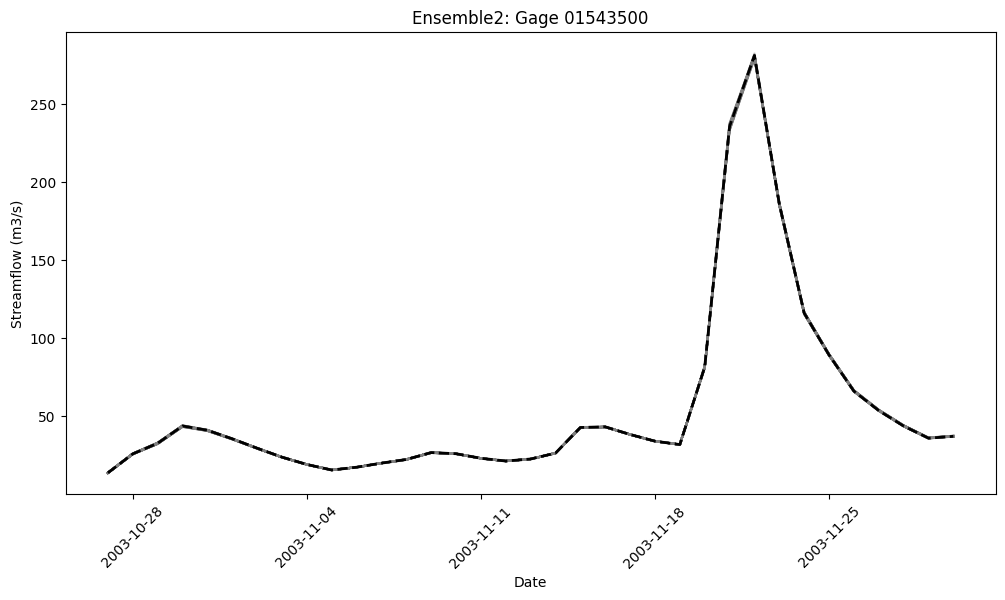

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


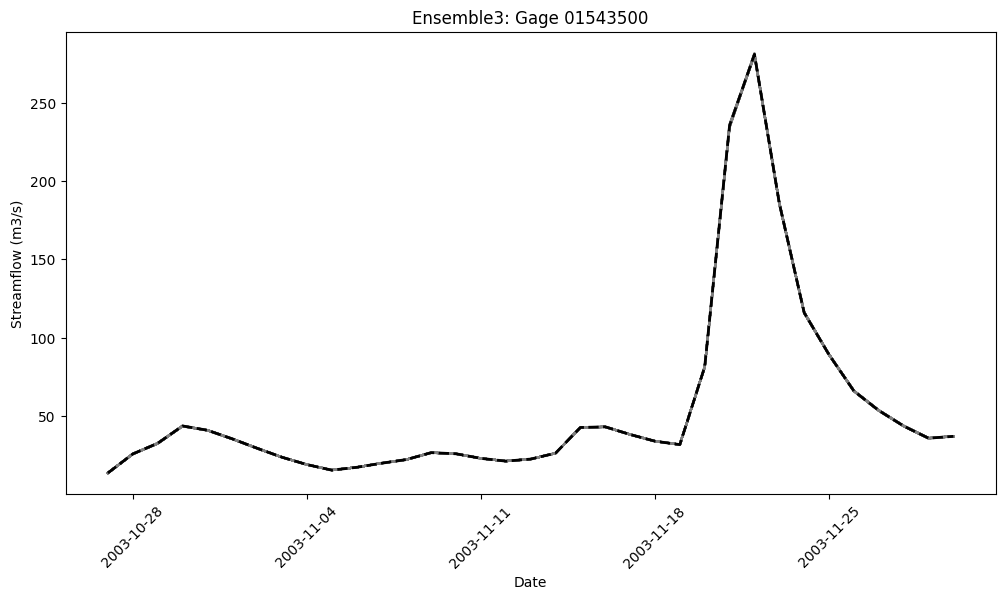

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


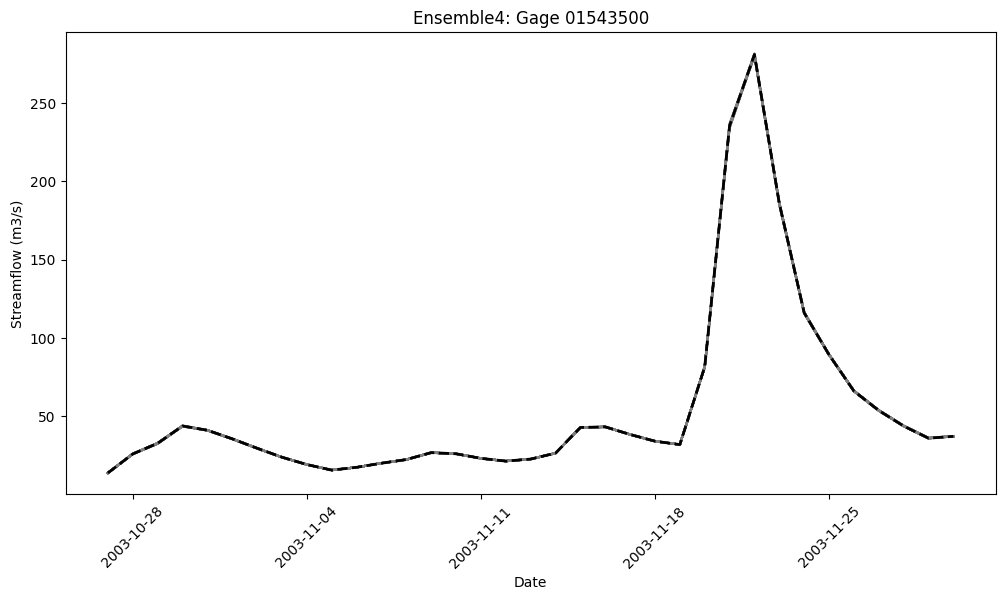

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


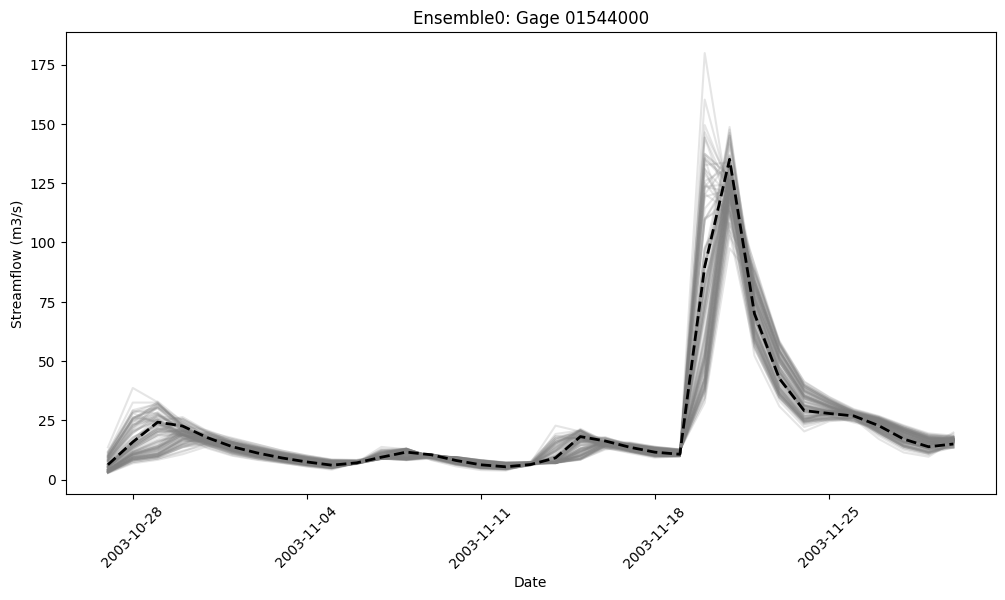

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


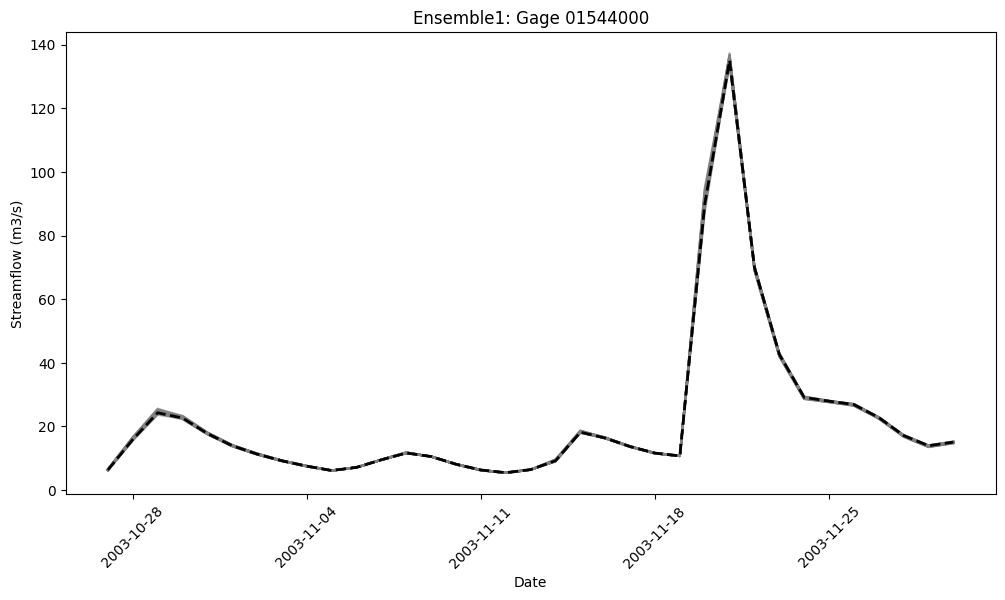

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


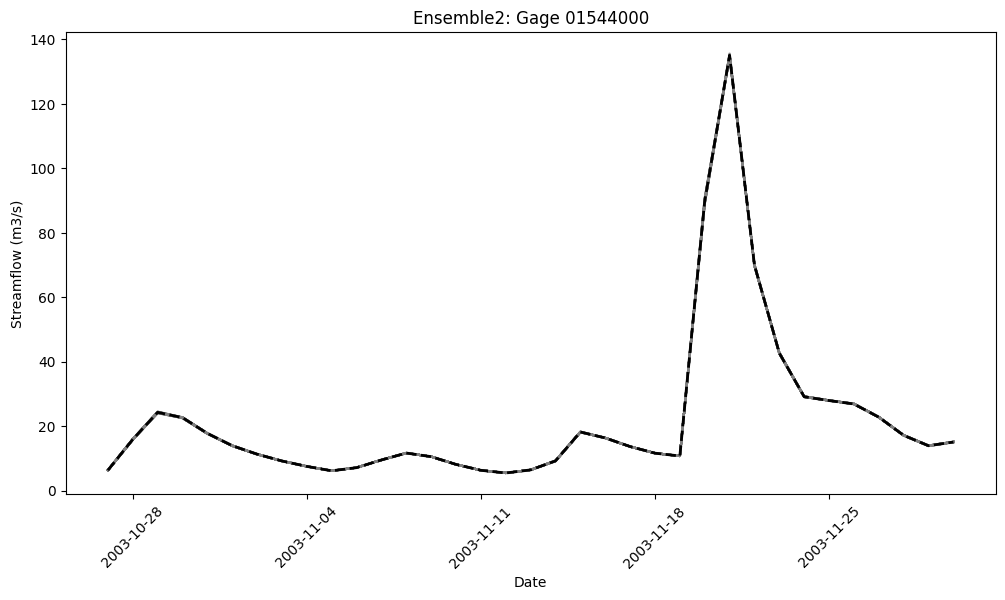

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


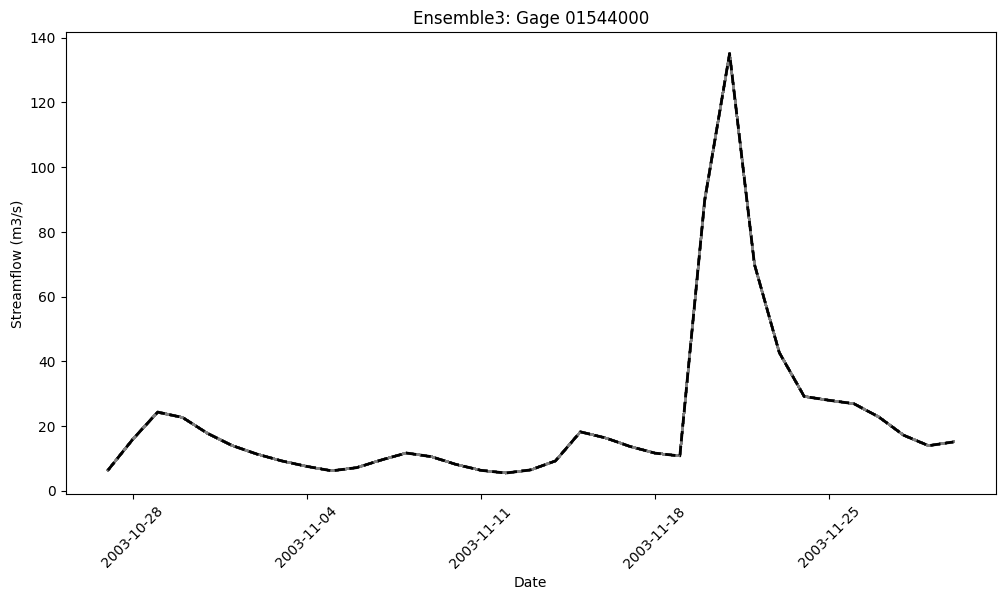

/tmp/ipykernel_2301148/408934101.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{ens}_{mem}"]=df[gage]


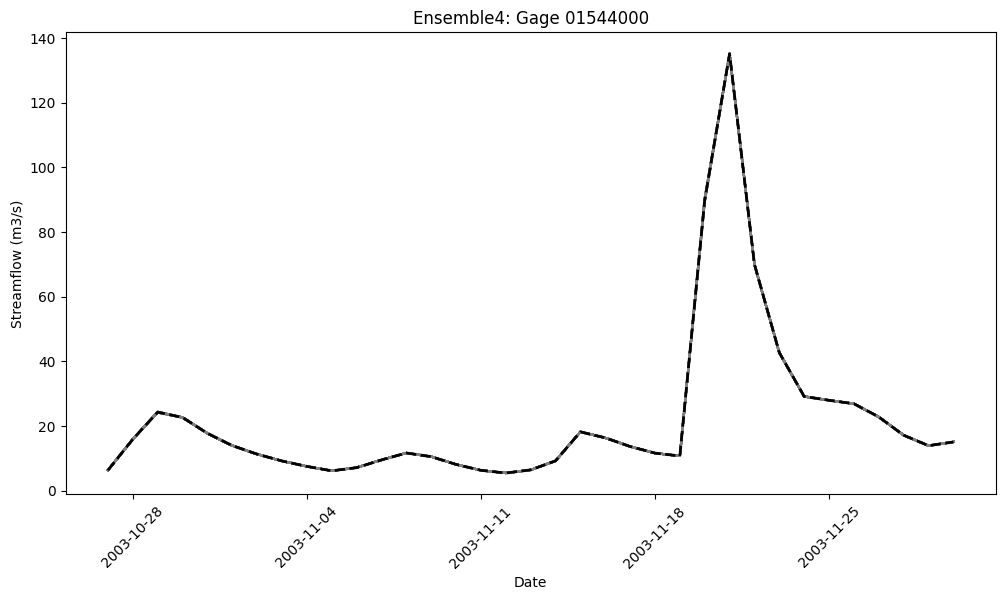

In [17]:
file_dir = '/home/at8471/c2_sbi_experiments/sbi_framework/outputs/sinnemahoning'
ens_list=[0,1,2,3,4]
gage_list=['01542500','01542810','01543000','01543500','01544000']
max_mems=99
file_name = 'streamflow_daily_pfsim.csv'
truth = pd.read_csv('/home/at8471/c2_sbi_experiments/sbi_framework/outputs/sinnemahoning/streamflow_daily_pfsim.csv', parse_dates=['date'],index_col='date')

for gage in gage_list:
    for ens in ens_list:
        result_df=pd.DataFrame()
        result_df['baseline']=truth[gage]
        for mem in range(0,max_mems+1):
            file_path=f"{file_dir}_{ens}_{mem}/{file_name}"
            df = pd.read_csv(file_path, parse_dates=['date'],index_col='date')
            if gage in df.columns:
                result_df[f"{ens}_{mem}"]=df[gage]
                
        # mean_series=result_df.mean(axis=1)
        # std_dev_series=result_df.std(axis=1)
        # sem_series=std_dev_series/np.sqrt(result_df.shape[1]-1)
        # upper_bound=mean_series+(1.96*sem_series)
        # lower_bound=mean_series-(1.96*sem_series)
        
        plt.figure(figsize=(12,6))

        for col in result_df.columns:
            plt.plot(result_df.index,result_df[col],color='grey',alpha=.2)
        plt.plot(result_df.index,result_df['baseline'],color='k',linestyle='--',linewidth=2,label='Truth')
        #plt.fill_between(result_df.index,lower_bound,upper_bound,color='red',alpha=.5,label='95% probability bound')
        plt.title(f'Ensemble{ens}: Gage {gage}')
        plt.xlabel('Date')
        plt.ylabel('Streamflow (m3/s)')
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())  # Tick on the first day of each month
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date labels
        plt.xticks(rotation=45) 
        #plt.legend(loc='upper right')
        plt.show()
        